### This notebook compares the similarity of gene sets for equivalent pathways from KEGG, Reactome and WikiPathways. The gene sets are sourced from ComPath/Bio2BEL and compared to BEL graphs parsed by PathMe.

In [1]:
import os
import itertools as itt
from collections import Iterable, defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from pybel import from_pickle, union

from pathme.constants import REACTOME_BEL, KEGG_BEL, WIKIPATHWAYS_BEL
from pathme.utils import get_files_in_folder, get_genes_in_graph
from pathme_viewer.graph_utils import add_annotation_key, add_annotation_value

from bio2bel_kegg import Manager as KeggManager
from bio2bel_reactome import Manager as ReactomeManager
from bio2bel_wikipathways import Manager as WikipathwaysManager


In [2]:
time.asctime()

'Tue Feb  5 17:27:50 2019'

In [3]:
# Initiate WikiPathways Manager
wikipathways_manager = WikipathwaysManager()
# Initiate Reactome Manager
reactome_manager = ReactomeManager()
# Initiate KEGG Manager
kegg_manager = KeggManager()

In [4]:
# Equivalent pathway IDs (ordered)
reactome_ids = ['R-HSA-5358508','R-HSA-209968','R-HSA-195721','R-HSA-5683057','R-HSA-71336','R-HSA-1257604','R-HSA-168898','R-HSA-983705','R-HSA-157118','R-HSA-109581','R-HSA-428157','R-HSA-5358351','R-HSA-71403','R-HSA-69306','R-HSA-5693571','R-HSA-1640170','R-HSA-9006936','R-HSA-165159','R-HSA-448424','R-HSA-74182','R-HSA-1170546']               
kegg_ids = ['hsa03430','hsa04918','hsa04310','hsa04010','hsa00030','hsa04151','hsa04620','hsa04662','hsa04330','hsa04210','hsa00600','hsa04340','hsa00020','hsa03030','hsa03450','hsa04110','hsa04350','hsa04150','hsa04657','hsa00072','hsa04917']
wikipathways_ids = ['WP531','WP1981','WP363','WP382','WP134','WP4172','WP75','WP23','WP61','WP254','WP1422','WP47','WP78','WP466','WP438','WP179','WP366','WP1471','WP2112','WP311','WP2037']

# Reactome pathways not contained in Reactome RDF file
REACTOME_BLACK_LIST = ['R-HSA-2025928','R-HSA-9604323', 'R-HSA-9013700','R-HSA-9017802','R-HSA-168927', 'R-HSA-9014325', 'R-HSA-9013508', 'R-HSA-9013973', 'R-HSA-9013957', 'R-HSA-9013695','R-HSA-9627069']

Methods used to get gene sets from BEL graphs 

In [5]:
def flatten(l):
    for el in l:
        if isinstance(el, Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el
            
def get_all_pathway_children_by_id(manager, reactome_id):
    
    children = []
    pathway = manager.get_pathway_by_id(reactome_id)
    
    if not pathway.children:
        return pathway.reactome_id  
   
    for child in pathway.children:
        children.append(get_all_pathway_children_by_id(manager, child.reactome_id))
    
    return children

def add_pathway_annotations(graph, resource_name, pathway_id):
    
    graph.annotation_pattern['Database'] = '.*'
    add_annotation_key(graph)
    add_annotation_value(graph, 'Database', resource_name)
    
    return graph

def get_bel_graph(resource_name, pathway_id):
    
    if resource_name == 'reactome':        
        pickle_path = os.path.join(REACTOME_BEL, pathway_id + '.pickle')
        
    elif resource_name == 'kegg':        
        pickle_path = os.path.join(KEGG_BEL, pathway_id + '_unflatten.pickle')
 
    elif resource_name == 'wikipathways':        
        pickle_path = os.path.join(WIKIPATHWAYS_BEL, pathway_id + '.pickle')

    bel_graph = from_pickle(pickle_path)
    
    return add_pathway_annotations(bel_graph, resource_name, pathway_id)


Create a dictionary for Reactome pathways with children

In [6]:
parent_to_child = dict()

for reactome_id in reactome_ids:
    
    all_children = get_all_pathway_children_by_id(reactome_manager, reactome_id)
    
    if isinstance(all_children, str):
        continue
        
    flattened_children = flatten(all_children)
    parent_to_child[reactome_id] = [pathway for pathway in flattened_children]

Get the bel-derived gene set for every equivalent pathway. In other words, these gene sets contain genes, proteins and RNA with the HGNC namespace and were parsed from the databases using PathMe.

In [7]:
kegg_bel_dict = dict()
reactome_bel_dict = defaultdict(list)
wikipathways_bel_dict = dict()

for counter, reactome_id in enumerate(reactome_ids):
    
    reactome_graphs = []  
    
    # Get BEL graph for KEGG pathway   
    kegg_bel_graph = get_bel_graph('kegg', kegg_ids[counter])
    # Get gene set for BEL graph
    kegg_bel_genes = get_genes_in_graph(kegg_bel_graph)
    # Get dictionary of KEGG pathway IDs and their corresponding gene sets
    kegg_bel_dict[kegg_ids[counter]] = kegg_bel_genes

    # Get BEL graph for WikiPathways pathway 
    wikipathways_bel_graph = get_bel_graph('wikipathways', wikipathways_ids[counter])
    # Get gene set for BEL graph
    wikipathways_bel_genes = get_genes_in_graph(wikipathways_bel_graph)
    # Get dictionary of WikiPathways pathway IDs and their corresponding gene sets
    wikipathways_bel_dict[wikipathways_ids[counter]] = wikipathways_bel_genes
        
    # Check if reactome ID is in black list 
    if reactome_id in REACTOME_BLACK_LIST:
        continue
    
    # If Reactome parent pathway has children, get merged graph of children
    if reactome_id in parent_to_child:            
        pathway_children = parent_to_child[reactome_id]

        for child in pathway_children:
            
            if child not in REACTOME_BLACK_LIST:

                reactome_bel_graph = get_bel_graph('reactome', child)
                reactome_graphs.append(reactome_bel_graph)
                
    # Get Reactome parent pathway graph
    else:
        reactome_graphs.append(get_bel_graph('reactome', reactome_id))
    
    for reactome_graph in reactome_graphs:
        # Get gene set for Reactome BEL graph
        reactome_bel_genes = get_genes_in_graph(reactome_graph)
        # Get dictionary of Reactome pathway IDs and their corresponding gene sets for each of its subpathways
        reactome_bel_dict[reactome_ids[counter]].append(reactome_bel_genes)    

If a Reactome pathway has children, flatten gene sets of the children to get the gene set for its parent pathway

In [8]:
reactome_flattened_dict = {}

for k,genes_list in reactome_bel_dict.items():

    if len(genes_list) > 0 and isinstance(list(genes_list)[0], set):
        genes_list = itt.chain.from_iterable(genes_list)
        
    reactome_flattened_dict[k] = genes_list


Get the genesets for each database derived from ComPath/Bio2BEL 

In [9]:
kegg_gene_set = kegg_manager.export_gene_sets()

kegg_gene_set = {
    kegg_manager.get_pathway_by_name(pathway_name).resource_id.replace('path:',''): gene_set
    for pathway_name, gene_set in kegg_gene_set.items()            
}

reactome_gene_set = reactome_manager.export_gene_sets()
reactome_gene_set = {
    reactome_manager.get_pathway_by_name(pathway_name).resource_id: gene_set
    for pathway_name, gene_set in reactome_gene_set.items()     
}

wikipathways_gene_set = wikipathways_manager.export_gene_sets()
wikipathways_gene_set = {
    wikipathways_manager.get_pathway_by_name(pathway_name).resource_id: gene_set
    for pathway_name, gene_set in wikipathways_gene_set.items()
}


For equivalent pathways in the databases, calculate the Jaccard index for gene sets from ComPath/Bio2BEL and from BEL graphs 

In [10]:
def jaccard_similarity(compath_genes_set, bel_genes_set):
    """Get Jaccard similarity for gene sets in 21 equivalent pathways from KEGG and BEL graphs.

    :param dict kegg_genes_set: gene sets for pathways in KEGG PATHWAYS database
    :param dict bel_genes_set: gene sets for BEL graphs
    :return: similarity index dictionary
    :rtype: int
    """    
    similarity_scores_dict = {}
    
    for (compath_key, compath_value), (bel_key, bel_value) in itt.product(compath_genes_set.items(),bel_genes_set.items()):
        
        if compath_key != bel_key:
            continue
            
        intersection = len(set.intersection(compath_value, bel_value))
        union = len(compath_value.union(bel_value))
        jaccard_index = intersection/union
        
        similarity_scores_dict[(compath_key, bel_key)] = jaccard_index
        
    return similarity_scores_dict



In [11]:
kegg_similarity_dict = jaccard_similarity(kegg_gene_set, kegg_bel_dict)
reactome_similarity_dict = jaccard_similarity(reactome_gene_set, reactome_flattened_dict)
wikipathways_similarity_dict = jaccard_similarity(wikipathways_gene_set, wikipathways_bel_dict)

### Visualize the similarity between gene sets from ComPath/Bio2BEL and those from PathMe/BEL graphs 

In [12]:
def get_similarity_heatmap(similarity_dict):
    
    ser = pd.Series(list(similarity_dict.values()),
                      index=pd.MultiIndex.from_tuples(similarity_dict.keys()))
    df = ser.unstack().fillna(0)
    
    sns.heatmap(df)

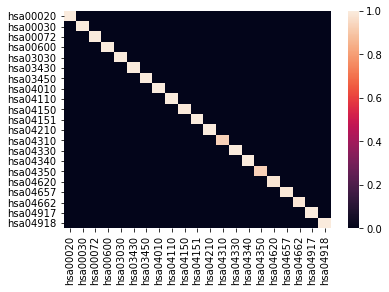

In [13]:
get_similarity_heatmap(kegg_similarity_dict)

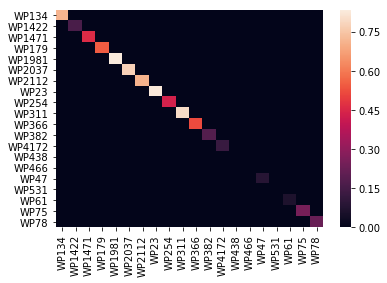

In [14]:
get_similarity_heatmap(wikipathways_similarity_dict)

The WP identifiers WP466, WP438 and WP531 have a Jaccard similarity index of 0. This is because they are purely graphical representations. Other identifiers (e.g., WP4172 and WP47) also have low similarity scores which can also be largely attributed to their represented as cartoons.

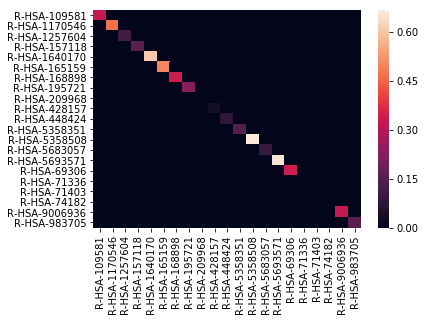

In [15]:
get_similarity_heatmap(reactome_similarity_dict)

The Reactome identifiers with similarity scores of 0 (i.e., R-HSA-71403, R-HSA-74182, R-HSA-71336, R-HSA-209968) do not contain genes or gene products in their BEL graph representations. Similarly, Reactome identifiers with low similarity also contain few or none genes or gene products.